# Train NeRF on Colab!

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/hw3

Mounted at /content/drive
/content/drive/MyDrive/hw3


In [2]:
%load_ext autoreload
%autoreload 2

!pwd

/content/drive/MyDrive/hw3


In [3]:
import os
import sys
import torch
need_pytorch3d=False

try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [4]:
!pip install pytorch_lightning wandb matplotlib kornia cprint einops rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import os
import time

import wandb
from cprint import cprint
import argparse

from configs import get_cfg_defaults

import torch
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

from datasets import make_datamodule
from trainer import NeRF
from raysampler import AllRaySampler, MonteCarloRaysampler

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.profilers import AdvancedProfiler

from utils.logging import init_logger

def get_intrinsics(dm: pl.LightningDataModule, stage: str='fit'):
    dataloader = {
        'fit': dm.train_dataloader,
        'eval': dm.val_dataloader,
        'test': dm.test_dataloader,
    }
    
    dm.setup(stage)
    it = iter(dataloader[stage]())
    batch = next(it)

    return batch['intrinsics']

def main(cfg):
    # Make datamodule
    dm = make_datamodule(cfg)
    cprint.warn(f"Datamodule made")

    # Get Batched Intrinsics
    train_intrinsics = get_intrinsics(dm=dm, stage='fit')
    eval_intrinsics = get_intrinsics(dm=dm, stage='eval')

    # Make model
    model = NeRF(cfg.learning_rate, (cfg.width, cfg.height), cfg=dict(cfg), train_intrinsics=train_intrinsics, eval_intrinsics=eval_intrinsics)
    device = "cpu" if cfg.no_cuda else "gpu"
    cprint.warn(f"Model NeRF made, running on " + device)

    # Unique timstamp for logging:
    ts = time.strftime("%Y%m%d-%H%M%S")

    # Prepare Logging
    log_dir = os.path.join(cfg.log_dir, cfg.experiment_name, ts)
    os.makedirs(log_dir)
    logger = WandbLogger(name=cfg.experiment_name, project=cfg.project_name, save_dir=log_dir, log_model=cfg.log_model_checkpoint)
    # logger.watch(model, log='all')

    # Prepare checkpointing and saving
    weight_dir = os.path.join(cfg.weight_dir, cfg.experiment_name, ts)
    os.makedirs(weight_dir)
    checkpoint_callback = ModelCheckpoint(
        dirpath=weight_dir,
        monitor='val_loss',
        filename= cfg.experiment_name + '-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min',
        every_n_epochs=1
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # aprofiler = AdvancedProfiler(filename='perf_logs')

    # Train!
    if device == 'gpu':
        trainer = pl.Trainer(accelerator=device, 
                             devices=torch.cuda.device_count(), 
                             logger=logger, 
                             log_every_n_steps=cfg.log_frequency,
                             accumulate_grad_batches=20,
                callbacks=[checkpoint_callback, lr_monitor], check_val_every_n_epoch=50, max_epochs=3000)
    else:
        trainer = pl.Trainer(accelerator=device, logger=logger, log_every_n_steps=cfg.log_frequency,
                callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()], check_val_every_n_epoch=1000, max_epochs=cfg.num_epochs)
    model = NeRF.load_from_checkpoint("/content/drive/MyDrive/hw3/weights/real-big-model-cont-img_is_200x200/20221206-122632/real-big-model-cont-img_is_200x200-epoch=7499-val_loss=0.00.ckpt",
      learning_rate=cfg.learning_rate, img_size=(cfg.width, cfg.height), cfg=dict(cfg), train_intrinsics=train_intrinsics, eval_intrinsics=eval_intrinsics)
    model.raysampler_test = AllRaySampler(
                    # img_size=img_size[0],
                    img_size=800,
                    n_pts_per_ray=cfg['raysampler']['num_pts'],
                    min_depth=cfg['raysampler']['min_depth'],
                    max_depth=cfg['raysampler']['max_depth'],
                    batch_size=1,
                    device=torch.device('cuda'),
                    K=eval_intrinsics
                )
    
    model.raysampler_train = MonteCarloRaysampler(
                img_size=cfg['height'],
                n_rays_per_image=cfg['raysampler']['num_rays'],
                n_pts_per_ray=cfg['raysampler']['num_pts'],
                min_depth=cfg['raysampler']['min_depth'],
                max_depth=cfg['raysampler']['max_depth'],
                device=torch.device('cuda'),
                K=train_intrinsics,
                batch_size=cfg['batch_size'],
                # stratified=cfg['raysampler']['stratified']
                stratified=True
            )
        
    trainer.fit(model, dm)

In [21]:
cfg = get_cfg_defaults()
cfg.model = 'nerf'
cfg.project_name = 'nerf-full-200'
cfg = init_logger('wandb', cfg)
cprint.info(cfg)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/PSNR_epoch,▁▄▆▇█▇▇▇▇▇▇▇▇▇▅▄▅▅▆▆▆▆▇▆▇▇▆▆▇▇█▇▇▇█▇█▇▆▄
train/PSNR_step,▁█
train/train_loss_epoch,█▄▃▂▂▂▂▂▂▂▂▂▂▂▄▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▁▂▂▂▁▂▁▂▃▅
train/train_loss_step,█▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,100
lr-Adam,0.0001
train/PSNR_epoch,27.27411
train/PSNR_step,27.05679


{'project_name': 'nerf-full-200', 'experiment_name': 'cont-real-big-model-cont-img_is_200x200-batch-10-stratified', 'log_dir': '/tmp/nerf/logs', 'weight_dir': './weights', 'log_frequency': 250, 'save_frequency': 1, 'log_model_checkpoint': True, 'script_mode': 'train', 'data_dir': 'data/bottles', 'split_dir': 'splits/bottles', 'width': 200, 'height': 200, 'load_ckpt_path': None, 'model_hparams': {'pos_emb_num': 10, 'dir_emb_num': 4, 'hidden_dim': 256}, 'model': 'nerf', 'raysampler': {'num_rays': 4096, 'num_pts': 64, 'min_depth': 0.1, 'max_depth': 5.0, 'stratified': True}, 'num_epochs': 4000, 'no_cuda': False, 'batch_size': 1, 'iterations': 20, 'num_workers': 5, 'learning_rate': 5e-05, 'scheduler_step_size': 2500, 'seed': 215}


Datamodule made
Model NeRF made, running on gpu
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                 | Params
----------------------------------------------------------
0 | model            | NeRFModel            | 435 K 
1 | raysampler_train | MonteCarloRaysampler | 0     
2 | raysampler_test  | AllRaySampler        | 0     
3 | raymarcher       | RayMarcher           | 0     
4 | eval_metrics     | MetricCollection     | 0     
----------------------------------------------------------
435 K     Trainable params
0         Non-trainable params
435

Sanity Checking: 0it [00:00, ?it/s]

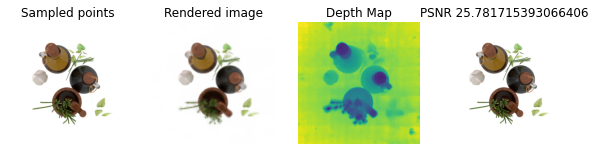

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line

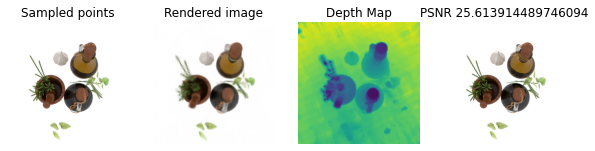

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

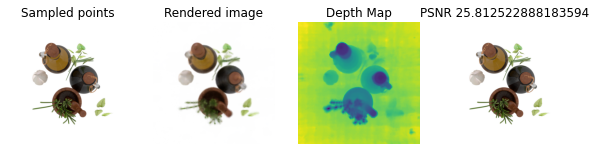

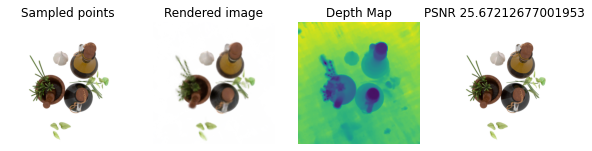

Validation: 0it [00:00, ?it/s]

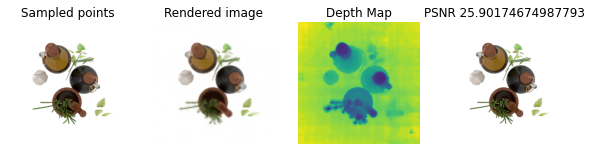

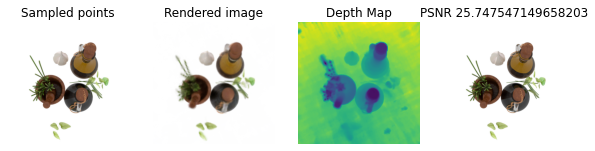

In [22]:
main(cfg)
# wandb.finish()